In [223]:
cd /Users/xl/Downloads/借啊/评分卡/模型监控

/Users/xl/Downloads/借啊/评分卡/模型监控


In [224]:
from pymongo import MongoClient
import pymongo
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pymysql.cursors

# 链接数据库

In [308]:
#建立MongoDB数据库连接
client = MongoClient('dds-k1a855c22baf8ec41111-pub.mongodb.ap-southeast-5.rds.aliyuncs.com', 3717)
db_auth = client.admin
#账号和密码
db_auth.authenticate('readonly','9skLyjBrvnqmCltkeqrazfqfoxc20')
# 链接数据库
db = client.uangtech_loan


# 链接MySQL数据库连接
dbsql=pymysql.connect(host="rr-k1as63vd06u3f2b61qo.mysql.ap-southeast-5.rds.aliyuncs.com", 
user="cashday_pro_read",password="Cashday_pro_read",database="uangtech_loan",port=3306, charset='utf8' )
# 使用cursor()方法获取操作游标
cur = dbsql.cursor()

# SQL 查询语句
sql_audit ="select loan_money_date, audit_order_no, over_due_days ,status from t_loan_audit_order \
     where loan_money_date >'2018-11-05'"

sql_risk = "select uid,loan_order_no, risk_order_no, status from t_risk_order  where create_time >'2018-11-05' "


# 执行SQL语句并获取结果
cur.execute(sql_audit)
results = cur.fetchall()

cur.execute(sql_risk)
res_risk = cur.fetchall()

In [309]:
#提取
df_audit = pd.DataFrame(list(results),columns= ['loan_money_date', 'audit_order_no','over_due_days','status'])

df_risk = pd.DataFrame(list(res_risk), columns = ['uid','loan_order_no', 'risk_order_no','risk_status'])

df_score = pd.DataFrame(list(db.t_sl_request.find({'createTime':{
                                                          "$gte": datetime(2018,11,6)
                                                          #,"$lte":datetime(2018,11,5)
                                                                 }},
                                                   {'_id':0,"riskOrderNo":1,"finalCheckOutput.score":1,"createTime":1,
                                                    'clientTypeCheck.ruleMark':1,'finalCheckOutput.finalCheckMark':1}
                                                  ,no_cursor_timeout = True)))

# 数据清洗与整合

In [310]:
#引擎数据清洗
df_score['score'] = df_score['finalCheckOutput'].map(lambda s: list(s.values())[1]).astype(float)
df_score['clientTypeCheck'] = df_score['finalCheckOutput'].map(lambda s: list(s.values())[0])

# 找到所有进模型的进件 score > 0
df_S = df_score[['clientTypeCheck','createTime','riskOrderNo','score']][df_score['score']>0]
df_S['yq_time'] = df_S['createTime'].dt.date

# 取过模型的数据且排序
# df = df_scorecard[df_scorecard['score']>0].sort_values(by = 'createTime',ascending = False)

#风控订单和订单join
df_loan_due = pd.merge(df_risk, df_audit, left_on ='loan_order_no',  right_on = 'audit_order_no',how = 'left')

#join引擎数据
df_alow = pd.merge(df_S, df_loan_due, left_on = 'riskOrderNo', right_on = 'risk_order_no',how = 'left')
df_alow = df_alow[df_alow['score']>0]

# 每日通过率及分数分布

In [322]:
time = '2018-11-28'

# 模型整体进件
mod_all =  df_alow[df_alow['yq_time'].map(str) == time].shape[0]
 

# 模型整体通过
mod_390 = df_alow[(df_alow['yq_time'].map(str) == time)&(df_alow['score']>418)].shape[0]
##信审整体通过 # risk_status 3：通过； 4：拒绝
xs_390 = df_alow[(df_alow['yq_time'].map(str) == time)&(df_alow['score']>418)&(df_alow['risk_status']!=4)].shape[0]


# 模型451通过
mod_451 = df_alow[(df_alow['yq_time'].map(str) == time)&(df_alow['score']>451)].shape[0]
##简审451通过
xs_451 = df_alow[(df_alow['yq_time'].map(str) == time)&(df_alow['score']>451)&(df_alow['risk_status']!=4)].shape[0]

#每日模型通过情况和信审通过情况
pd.DataFrame(data = [[time, mod_all, mod_390 , xs_390, mod_451, xs_451]],
             columns=['决策时间','模型整体进件', '模型整体通过','信审整体通过','模型451通过','简审451通过'])

,决策时间,模型整体进件,模型整体通过,信审整体通过,模型451通过,简审451通过
0,2018-11-28,32,16,12,8,5


# 每日贷后表现

In [313]:
# 找到status为4（已完成）、6（已逾期）的所有进件
df_check = df_alow[(df_alow['createTime']>'2018-11-6 08:00:00')&(df_alow['status'].isin([4,6]))]

df_check['YN_date'] = df_check['loan_money_date'].dt.date

/Users/xl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [315]:
Time = '2018-11-14'
TIME = pd.DataFrame([Time],columns=['放款日期'])

# Time 全部 status为4（已完成）、6（已逾期）
loan_all = df_check[df_check['YN_date'].map(str) == Time ][['riskOrderNo','status','over_due_days']]
l_all = loan_all.groupby(['status','over_due_days']).count().reset_index()
l_all.columns = ['status','over_due_days','全体个数']

#Time 451 status为4（已完成）、6（已逾期）
loan_451 = df_check[(df_check['YN_date'].map(str) == Time )&(df_check['score']>451)]\
          [['riskOrderNo','status','over_due_days']]
l_451 = loan_451.groupby(['status','over_due_days']).count().reset_index()
l_451.columns = ['status','over_due_days','451以上个数']

# 贷后表现——整体
pd.concat([TIME,l_all,l_451],1) 

,放款日期,status,over_due_days,全体个数,status,over_due_days,451以上个数
0,2018-11-14,4.0,0.0,36,4.0,0.0,24
1,NaN,4.0,1.0,1,4.0,1.0,1
2,NaN,6.0,1.0,25,6.0,1.0,20


In [316]:
# 引入新户
df_new = pd.read_excel('/Users/xl/Downloads/借啊/评分卡/二期评分卡—新户/1106-1118新户.xlsx')
df_check_new = pd.merge(df_check, df_new,left_on = 'risk_order_no',right_on = 'risk_order_no',how = 'inner')
df_check_new['YN_date'] = df_check_new['loan_money_date_y'].dt.date

In [337]:
t_new = '2018-11-12'
T = pd.DataFrame([t_new],columns=['放款日期'])

# 新户总体情况
loan_new_all = df_check_new[(df_check_new['YN_date'].map(str) == t_new)][['riskOrderNo','status_x','over_due_days']]
l_new_all = loan_new_all.groupby(['status_x','over_due_days']).count().reset_index()
l_new_all.loc[0,'sum_all']=l_new_all['riskOrderNo'].sum()


# 2018-11-10 新户451情况
loan_new_451 = df_check_new[(df_check_new['YN_date'].map(str) == t_new) & (df_check_new['score']>451)&\
                            (df_check_new['借款次数']==1)][['riskOrderNo','status_x','over_due_days']]
l_new_451 = loan_new_451.groupby(['status_x','over_due_days']).count().reset_index()
l_new_451.loc[0,'sum_451']=l_new_451['riskOrderNo'].sum()


#贷后表现——新、老户
pd.concat([T,l_new_all,l_new_451],1) 

,放款日期,status_x,over_due_days,riskOrderNo,sum_all,status_x,over_due_days,riskOrderNo,sum_451
0,2018-11-12,4.0,0.0,25,34.0,4.0,0.0,15,23.0
1,NaN,4.0,1.0,2,NaN,4.0,1.0,1,NaN
2,NaN,6.0,3.0,7,NaN,6.0,3.0,7,NaN


# 分数分布

In [335]:
df_sc = df_alow.copy()
df_sc['bin'] = pd.cut(df_sc['score'],[300,360,380,400,420,450,500,600] ).map(str).sort_values()
df_sc = df_sc[df_sc['createTime'].dt.date.map(str) == '2018-11-28']

Text(0.5,1,'2018-11-27')

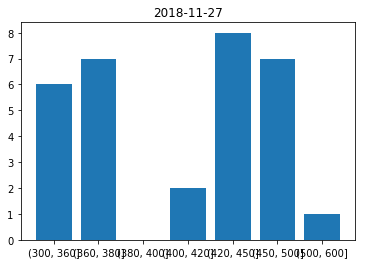

In [336]:
plot_score = df_sc.groupby('bin').count().reset_index()
plt.bar(plot_score['bin'],plot_score['createTime'])
plt.title('2018-11-27')